# Stochastic Simulation

*Winter Semester 2024/25*

17.01.2025

Prof. Sebastian Krumscheid<br>
Assistants: Stjepan Salatovic, Louise Kluge

<h3 align="center">
Exercise sheet 09
</h3>

---

<h1 align="center">
QMC and LH sampling
</h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.special import erf
from scipy.special import factorial
from scipy.stats.qmc import Sobol
from scipy.stats import norm
from scipy.stats import linregress
from typing import Callable, Tuple
from tqdm.notebook import tqdm

from ipywidgets import interact

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

**On randomized QMC formulas**

Let $P=\{X_1,\dots,X_N\}$, $X_i\in \mathbb{R}^d$, be a low-discrepancy sequence and denote the QMC quadrature by $\hat{\mu}_{QMC}=\frac{1}{N}\sum_{i=1}^N\psi(X_i)$. We are interested in estimating the error $|\mu-\hat{\mu}_{QMC}|$. Notice that since the points $X_i$ are _not_ i.i.d., we can't use a variance estimator or a CLT as in MC. In order to be able to do this, we can _randomize_ the QMC formula. Let $U_j\overset{iid}{\sim}\mathcal{U}([0,1]^d)$, $j=1,\dots,K$. If the set of points $P$ is a low discrepancy point set, so is the _randomly shifted point set_ $P_{U,j}:=\{ \{X_1+U_j\},\dots,\{X_N+U_j\}\}$, where $\{\cdot\}$ represents the fractional part. Moreover, since $U_j\overset{iid}{\sim}\mathcal{U}([0,1]^d)$, so is $\{X_i+U_j\}$ for any $i=1,\dots,N$. Thus, we can apply a Monte Carlo estimator on $\hat{\mu}_{QMC}$, by computing $K$ independent estimators $\hat{\mu}_{QMC}^{j}$ for each of the randomly shifted point sets $P_{U,j},$ and then averaging out the estimators. This in turn results in an unbiased estimator $\hat{\hat{\mu}}_{QMC}$ of $\mu$, for which we can use the standard variance estimator and CLT results. C.f the lecture notes for more details.

**On generating low-discrepany sequences**

To use the Sobol sequence generator from [`scipy.stats.qmc`](https://docs.scipy.org/doc/scipy/reference/stats.qmc.html), you can create an instance of the [`Sobol`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.Sobol.html) class with the desired dimension, and then use its `random` method to generate samples. Here's an example of how to use it:

```python
# Create a Sobol sequence generator
sobol = Sobol(d=2)

# Generate samples
N = 1000  # Number of samples
samples = sobol.random(N)
```

**Note:** The Sobol sequence is automatically randomized through the use of the `scramble` keyword argument for the [`Sobol`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.Sobol.html) class. By default, this is set to `True`.

## Exercise 1

Consider the problem of approximating the integral
\begin{equation*}
I_d(f) = \int_{{[0,1]}^d}f(\mathbf{x})\,d\mathbf{x}\;,
\end{equation*}
for some given function $f\colon{[0,1]}^d\to \mathbb{R}$. In this exercise we
will investigate the approximation qualities of different estimators
of $I_d(f)$ for various functions $f$, which differ mainly by their
regularity. Specifically, for each function listed below address to the
following points. Perform all computations at least for $d=2$ and
$d=20$.

**List of functions**

Investigate the approximation techniques for $I_d(f)$ mentioned above
for the following functions $f\colon {[0,1]^d}\to \mathbb{R}$, with
$\mathbf{x} = (x_1,\dots, x_d)$. Please note that a testing suite with several of the function definitions listed below can be found [here](https://people.math.sc.edu/Burkardt/c_src/testpack/testpack.html).

1. **Oscillatory function:**
	$f(\mathbf{x}) = \cos\left( 2\pi w_1 + \sum_{j=1}^d c_j x_j\right)$, with
	$c_j=9/d$, $w_1=\frac{1}{2}$.

	Exact solution:
	\begin{equation*}
	I_d(f) = \Re\left(e^{i2\pi w_1}\prod_{j=1}^d \frac{1}{ic_j}(e^{ic_j}-1)\right)\;,
	\end{equation*}
	where $i$ denotes the imaginary unit and $\Re(z)$ the real part of
	$z\in\mathbb{C}$.

2. **Product peak:**
	$f(\mathbf{x}) = \prod_{j=1}^d \left( c_j^{-2} + \left( x_j - w_j
	\right)^2\right)^{-1}$, with $c_j=7.25/d$ and $w_j=\frac{1}{2}$.

	Exact solution:
	\begin{equation*}
	I_d(f) = \prod_{j=1}^d c_j\left(\arctan(c_j(1-w_j)) + \arctan(c_jw_j)\right)\;.
	\end{equation*}

3. **Gaussian:**
	$f(\mathbf{x}) = \exp\left( - \sum_{j=1}^d c_j^2 (x_j - w_j)^2 \right)$,
	with $c_j=7.03/d$ and $w_j=\frac{1}{2}$.

	Exact solution:
	\begin{equation*}
	I_d(f) =  \prod_{j=1}^d \frac{\sqrt{\pi}}{2c_j} \Bigl(\text{erf}\bigl(c_j (1-w_j)\bigr) + \text{erf}(c_j w_j)\Bigr)\;.
	\end{equation*}

4. **Continuous function:**
	$f(\mathbf{x}) = \exp\left( - \sum_{j=1}^d c_j |x_j - w_j| \right)$, with
	$c_j=2.04/d$ and $w_j=\frac{1}{2}$.

	Exact solution:
	\begin{equation*}
	I_d(f) = \prod_{j=1}^d \frac{1}{c_j}\left(2-e^{-c_j w_j}-e^{-c_j(1-w_j)}\right)\;.
	\end{equation*}

5. **Discontinuous function:** 
	\begin{equation*}
	f(\mathbf{x}) =
	\begin{cases} 
	0 & \text{if } x_1 > w_1 \text{ or } x_2 > w_2 \\
	\exp\left( \sum_{j=1}^d c_j x_j \right) & \text{otherwise},
	\end{cases}
	\end{equation*}
	with $c_j=4.3/d$,  $w_1=\frac{\pi}{4}$, and $w_2=\frac{\pi}{5}$.

	Exact solution:
	\begin{equation*}
	I_d(f) = \frac{\prod_{j=3}^d (e^{c_j}-1)}{\prod_{j=1}^d c_j}(e^{c_1 w_1}-1)(e^{c_2 w_2}-1)\;.
	\end{equation*}

6. **Volume of the simplex:** 
	\begin{equation*}
	f(\mathbf{x}) =
	\begin{cases} 1 & \text{if } \sum_{j=1}^d x_j \leq 1 \\
	0 & \text{otherwise.}
	\end{cases} 
	\end{equation*}

	Exact solution:
	\begin{equation*}
	I_d(f) = \frac{1}{d!}\;.
	\end{equation*}

We have implemented all of the functions listed above using Python [classes](https://docs.python.org/3/tutorial/classes.html). Each class has a `function()` method (which evaluates $f$) and an `exact_solution()` method (which yields the exact solution $I_d(f)$).
Here's a quick example of how to use them:

```python
# Create an instance of the Oscillatory problem for d=2
problem = Oscillatory(d=2)

# Evaluate the function at x=[0.1, 0.2]
print(problem.function([0.1, 0.2]))

# ... or at N=1000 random points
N = 1000
print(problem.function(np.random.rand(N, 2)))

# Compute the exact solution
print(problem.exact_solution())
```

In [3]:
class Oscillatory:
    def __init__(self, d, w1=0.5):
        self.d = d
        self.w1 = w1
        self.c = 9.0 / d * np.ones(d)

    def function(self, x):
        x = np.atleast_2d(x)
        return np.cos(2 * np.pi * self.w1 + np.sum(self.c * x, axis=1))

    def exact_solution(self):
        return np.real(np.exp(1j * 2 * np.pi * self.w1) * np.prod(1 / (1j * self.c) * (np.exp(1j * self.c) - 1)))

In [4]:
class ProductPeak:
    def __init__(self, d, w=0.5):
        self.d = d
        self.w = w
        self.c = 7.25 / d * np.ones(d)

    def function(self, x):
        x = np.atleast_2d(x)
        return np.prod(self.c**(-2) + (x - self.w)**2, axis=1)**(-1)

    def exact_solution(self):
        return np.prod(self.c * (np.arctan(self.c * (1 - self.w)) + np.arctan(self.c * self.w)))

In [5]:
class Gaussian:
    def __init__(self, d, w=0.5):
        self.d = d
        self.w = w
        self.c = 7.03 / d * np.ones(d)

    def function(self, x):
        x = np.atleast_2d(x)
        return np.exp(-np.sum(self.c**2 * (x - self.w)**2, axis=1))

    def exact_solution(self):
        return np.prod(np.sqrt(np.pi) / (2 * self.c) * (erf(self.c * (1 - self.w)) + erf(self.c * self.w)))

In [6]:
class Continuous:
    def __init__(self, d, w=0.5):
        self.d = d
        self.w = w
        self.c = 2.04 / d * np.ones(d)

    def function(self, x):
        x = np.atleast_2d(x)
        return np.exp(-np.sum(self.c * np.abs(x - self.w), axis=1))

    def exact_solution(self):
        return np.prod(1 / self.c * (2 - np.exp(-self.c * self.w) - np.exp(-self.c * (1 - self.w))))

In [7]:
class Discontinuous:
    def __init__(self, d, w1=np.pi/4, w2=np.pi/5):
        self.d = d
        self.w1 = w1
        self.w2 = w2
        self.c = 4.3 / d * np.ones(d)

    def function(self, x):
        x = np.atleast_2d(x)
        return np.exp(np.sum(self.c * x, axis=1)) * (1 - ((x[:, 0] > self.w1) | (x[:, 1] > self.w2)))

    def exact_solution(self):
        return np.prod((np.exp(self.c) - 1)[2:]) / np.prod(self.c) * (np.exp(self.c[0] * self.w1) - 1) * (np.exp(self.c[1] * self.w2) - 1)

In [8]:
class SimplexVolume:
    def __init__(self, d):
        self.d = d

    def function(self, x):
        x = np.atleast_2d(x)
        return (np.sum(x, axis=1) <= 1).astype(int)

    def exact_solution(self):
        return 1 / factorial(self.d)

1. Implement a _crude Monte Carlo_ estimator to approximate the integral $I_d(f)$.
Estimate the error using the central limit theorem (CLT). Plot both
the exact error (c.f. exact solutions) and the CLT-based
error estimate as functions of the number of used samples $M$, say,
and estimate the convergence rate. 

In [9]:
def crude_monte_carlo(func: Callable, d: int, M: int) -> Tuple[float, float]:
    """
    Approximates the integral of a function over a d-dimensional unit hypercube using the crude Monte Carlo method.

    Args:
        func (callable): The function to integrate. It should accept a numpy array with shape (M, d) where M is the number of points and d is the dimension.
        d (int): The dimension of the domain of integration.
        M (int): The number of random points to generate for the Monte Carlo simulation.

    Returns:
        tuple: A tuple containing the integral approximation and the standard error estimate.
    """
    X = np.random.rand(M, d)
    Y = func(X)
    integral_approx = np.mean(Y)
    error_estimate = np.std(Y, ddof=1) / np.sqrt(M)
    
    return integral_approx, error_estimate

2. Implement a _Latin Hypercube Sampling_ estimator using $N$
points in the hypercube to approximate $I_d(f)$. Estimate the error using a sample variance estimator based on $K$
repetitions of the Latin Hypercube Sampling estimator. Again, plot
both the exact error and an asymptotic confidence interval based
error estimate as functions of the number of points $N$, say, and
estimate the convergence rate.  

In [10]:
def lhs(d: int, N: int) -> np.array:
    """
    Generate a Latin Hypercube Sampling (LHS) design.

    Args:
        d (int): The number of dimensions or variables.
        N (int): The number of sampling points.

    Returns:
        np.array: A numpy array of size N by d, where each row represents a sample and each column represents a dimension.
    """
    U = np.random.rand(N, d)
    pi = np.stack(
        [np.random.permutation(N) for _ in range(d)]
    ).T
    X = (U + pi) / N
    return X

In [11]:
def latin_hypercube_sampling(func: Callable, d: int, N: int, K: int=20) -> Tuple[float, float]:
    """
    Approximates the integral of a function using the Latin Hypercube Sampling method.

    Args:
        func (callable): The function to integrate.
        d (int): The dimension of the domain.
        N (int): The number of LHS points to use.
        K (int): The number of repetitions for error estimation.

    Returns:
        tuple: The integral approximation and the error estimate.
    """
    integral_approximations = np.zeros(K)
    for k in range(K):
        X = lhs(d, N)
        Y = func(X)
        integral_approximations[k] = np.mean(Y)
    
    integral_approx = np.mean(integral_approximations)
    error_estimate = np.std(integral_approximations, ddof=1) / np.sqrt(K)
    
    return integral_approx, error_estimate

3. Implement a _Quasi Monte Carlo_ (QMC) estimator to
approximate the integral $I_d(f)$. Use SciPy's Sobol method (hint on the top of this notebook) to
generate Sobol sequences. Estimate the error using the CLT by estimating the variance with a
_randomized QMC_. Once again, plot both the exact error and estimated error based on random shifts as functions of the number of $N$ and estimate the convergence rate.

In [12]:
def quasi_monte_carlo(func: Callable, d: int, N: int, K: int=20) -> Tuple[float, float]:
    """
    Approximates the integral of a function using the Quasi Monte Carlo method with Sobol sequences.

    Args:
        func (callable): The function to integrate.
        d (int): The dimension of the domain.
        N (int): The number of Sobol sequence points to use.
        K (int): The number of repetitions for error estimation.

    Returns:
        tuple: The integral approximation and the error estimate.
    """
    integral_approximations = np.zeros(K)
    for k in range(K):
        X = Sobol(d).random(N)
        Y = func(X)
        integral_approximations[k] = np.mean(Y)

    integral_approx = np.mean(integral_approximations)
    error_estimate = np.std(integral_approximations, ddof=1) / np.sqrt(K)
    
    return integral_approx, error_estimate

In [13]:
def convergence_rates_plot(problem, d: int, ax=None, plot_legend=True):
    """
    Plots the convergence rate for the given problem using crude Monte Carlo,
    Latin hypercube sampling, and quasi Monte Carlo.
    """
    problem = problem(d)
    M_values = np.logspace(2, 4.5, 10, dtype=int)
    errors = np.zeros((len(M_values), 3))
    error_estimates = np.zeros((len(M_values), 3))
    
    reps = 1
    
    for i, M in enumerate(M_values):
        for j, method in enumerate([
            crude_monte_carlo,
            latin_hypercube_sampling,
            quasi_monte_carlo
        ]):
            error_ = 0
            error_estimate_ = 0
            for _ in range(reps):
                integral_approx, error_estimate = method(problem.function, problem.d, M)
                error_ += np.abs(problem.exact_solution() - integral_approx)
                error_estimate_ += error_estimate
        
            errors[i, j] = error_ / reps
            error_estimates[i, j] = error_estimate_ / reps

    # If no axes object is provided, create a new one
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the exact errors and the CLT-based error estimates
    ax.loglog(M_values, errors, label=["MC", "LHS", "QMC"])
    ax.set_prop_cycle(None)
    ax.loglog(M_values, error_estimates, "--")
    _, intercept_mc, _, _, _ = linregress(np.log(M_values), np.log(errors[:, 0]))
    ax.loglog(M_values, np.exp(intercept_mc) * M_values ** -0.5, "k--", label="$M^{-1/2}$")
    _, intercept_qmc, _, _, _ = linregress(np.log(M_values), np.log(errors[:, 2]))
    ax.loglog(M_values, np.exp(intercept_qmc) * M_values ** -1., "k-.", label="$M^{-1}$")
    ax.set_xlabel("M")
    ax.set_ylabel("Error")
    ax.set_title(problem.__class__.__name__)
    ax.grid()

    if plot_legend:
        ax.legend()

In [14]:
problems = [
    Oscillatory,
    ProductPeak,
    Gaussian,
    Continuous,
    Discontinuous,
    SimplexVolume,
]

As predicted by the theory, the crude Monte Carlo method always shows a convergence of $\mathcal{O}(M^{-1/2})$ regardless of the regularity and the dimension of the integrand. 
In contrast, significant efficiency gains are possible using the Quasi Monte Carlo method, and to a lesser extent also the Latin Hypercube sampling method, provided the function
$f$ is smooth. 
These gains degenerate as the dimension $d$ increases, though. 
Convergence plots of each function for $d=2$ (upper) and $d=20$ (lower) as a function of the number of samples $M$ are shown in the Figures down below. The error estimator for QMC and LHS is computed over $K=20$ samples. The solid lines correspond to the exact, and the dashed lines to the estimated errors.

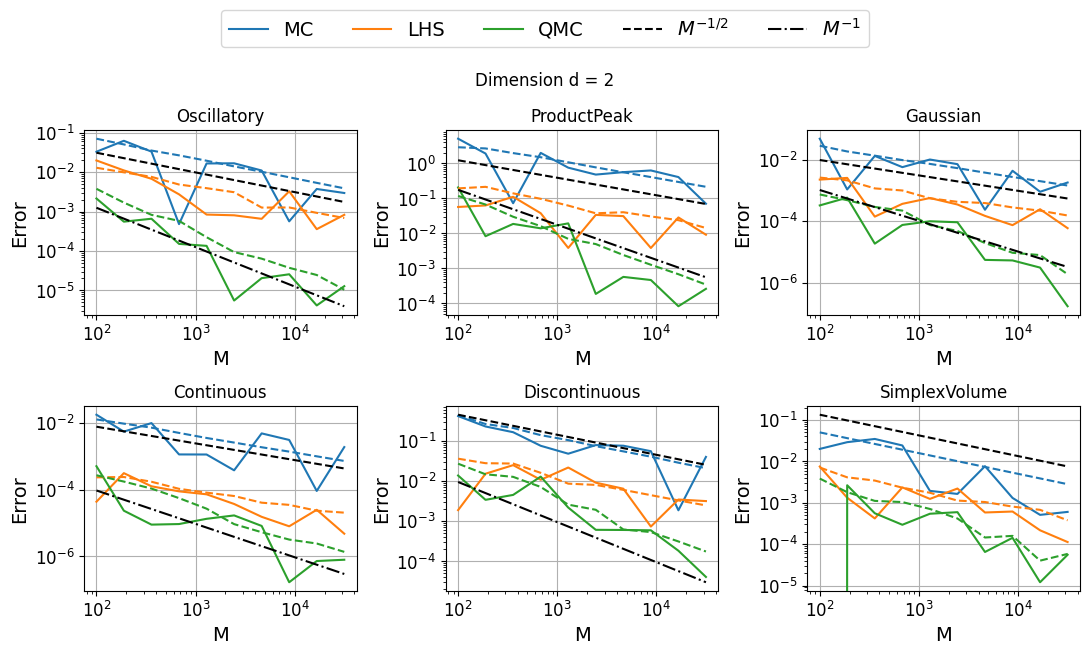

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle("Dimension d = 2")

for i, ax in enumerate(axs.ravel()):
    convergence_rates_plot(problems[i], d=2, ax=ax, plot_legend=False)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=5)
plt.tight_layout()

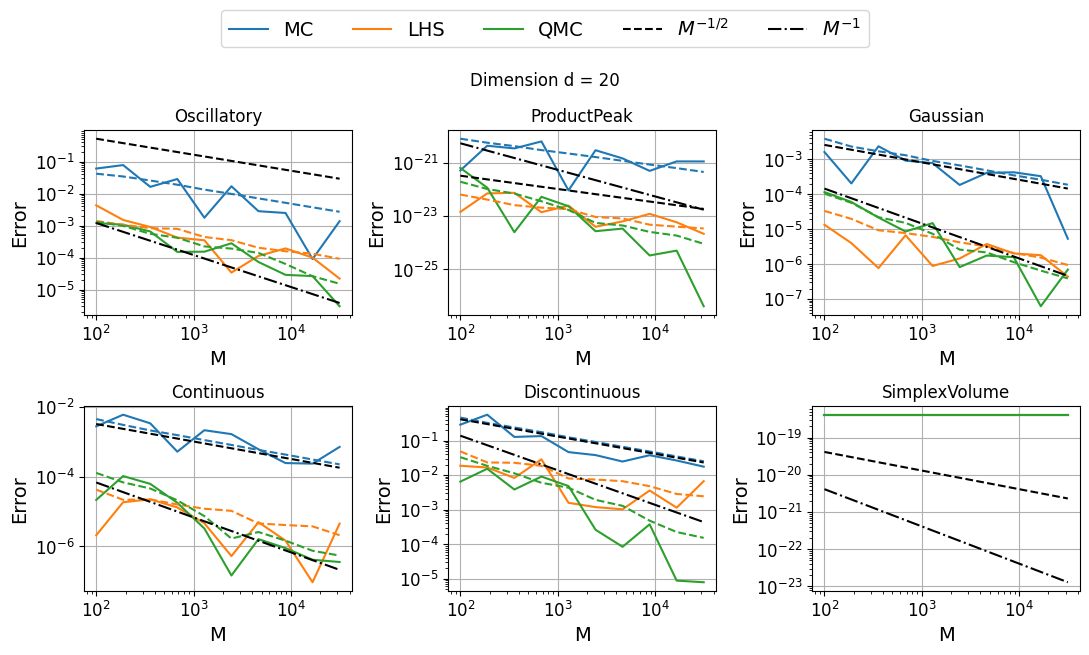

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle("Dimension d = 20")

for i, ax in enumerate(axs.ravel()):
    convergence_rates_plot(problems[i], d=20, ax=ax, plot_legend=False)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=5)
plt.tight_layout()

## Exercise 2

Consider the random boundary value problem (BVP)
\begin{equation*}
  \left\{
  \begin{aligned}
    \bigl(a(x,\omega) u'(x,\omega)\bigr)^\prime &= 0\;,\quad \text{in }(0,L)\;,\\
    u(0,\cdot) &= 0\;,\\
    a(L,\cdot) u'(L,\cdot) &= 1\;,
  \end{aligned}
  \right.
\end{equation*}
where $\omega$ represents an elementary random event, so that
$a\equiv a(x,\omega)$ is a random field. The BVP is a simplified model
for a linear beam of length $L$, which is fixed on one side ($x=0$)
and free on the other at which a unit load is applied. Here, the
random field $a$ models the beam's spatially varying uncertain
material properties. We are interested in quantifying the resulting
uncertainty on the beam's displacement at the free
end-point. Specifically, we are interested in studying the expected
value of the random variable
\begin{equation*}
  Z\equiv Z(\omega) := u(L,\omega) = \int_0^L\frac{1}{a(x,\omega)}\,dx\;.
\end{equation*}
However, $Z$ is usually not computable for a general elasticity
coefficient $a$. Instead, we consider the computable, approximate
random quantity of interest $Z_I$, which is obtained by approximating
the integral by the midpoint rule on a uniform grid,
\begin{equation*}
  Z_I \equiv Z_I(\omega) := h\sum_{i=1}^{I-1}\frac{1}{a\bigl(x_i+\frac{h}{2},\omega\bigr)}\;,
\end{equation*}
with $x_i = ih$, $i=0,\dots, I\in\mathbb{N}$, and $h = L/I$.

We are interested in approximating $\mathbb{E}[Z_I]$ for $L=1$
for two different elasticity coefficients:

1. For $\mu=1$ and $\sigma=4$, let
$$
a_1(x,\omega) = \mu + \frac{\sigma}{\pi^2}\sum_{n=1}^d\frac{\cos(\pi n x)}{n^2}Y_n(\omega)\;,\quad
    Y_n(\omega)\sim U(-1,1)\text{ i.i.d.}
$$


2. For $a_2(x,\omega) = \exp\bigl(\kappa(x,\omega)\bigr)$, let
$$
\kappa(x,\omega) = x + \sqrt{2}\sum_{n=1}^d\frac{\sin\bigl((n-\frac{1}{2})\pi x\bigr)}{(n-\frac{1}{2})\pi} Y_n(\omega)\;,\quad Y_n(\omega)\sim \mathcal{N}(0,1)\text{ i.i.d.}
$$

To that end, approximate $\mathbb{E}[Z_I]$ for various values of $d$ and
for various sub-divisions $I$ using (a) a crude Monte Carlo method, (b) Latin Hybercube Sampling (LHS) and (c) Quasi Monte Carlo (QMC) sampling.
Use repeated LHS and randomized QMC to estimate the error and provide asymptotic confidence intervals.


In [17]:
def a1(x: np.array, w: np.array, mu: float=1, sigma: float=4) -> np.array:
    """
    Elasticity coefficient a_1.

    Args:
        x (np.array): Quadrature grid, a numpy array of size I + 1.
        w (np.array): Samples, a numpy array of size (N, d).
        mu (float, optional): A scaling factor, defaults to 1.
        sigma (float, optional): Another scaling factor, defaults to 4.

    Returns:
        np.array: Coefficient evaluated on the grid for the N samples, a numpy array of size (N, I + 1).
    """
    w = 2 * w - 1    # Rescale w from (0, 1) to (-1, 1)
    d = w.shape[1]
    n = np.arange(1, d + 1)
    x = x.reshape(-1, 1)
    sum_term = np.einsum("id, nd -> ni", np.cos(np.pi * x * n) / n ** 2, w)
    return mu + sigma / np.pi**2 * sum_term

Here's a small checkpoint to test whether your function is imlemeted correctly. If the assert statement doesn't throw an error, your function is implemented correctly.

In [18]:
# CHECKPOINT

x = np.linspace(-1, 1, 5)
w = np.arange(1, 7).reshape(3, 2) / 7
expected = np.array(
    [
        [1.24606573, 1.04342336, 0.66708754, 1.04342336, 1.24606573],
        [1.07237227, 0.98552555, 0.95657664, 0.98552555, 1.07237227],
        [0.89867882, 0.92762773, 1.24606573, 0.92762773, 0.89867882]
    ]
)
assert np.allclose(a1(x, w), expected)

In [19]:
def a2(x: np.array, w: np.array) -> np.array:
    """
    Elasticity coefficient a_2.

    Args:
        x (np.array): Quadrature grid, a numpy array of size I + 1.
        w (np.array): Samples, a numpy array of size (N, d).

    Returns:
        np.array: Coefficient evaluated on the grid for the N samples, a numpy array of size (N, I + 1).
    """
    w = norm.ppf(w)    # Inverse transform sampling to Normal distribution
    d = w.shape[1]
    n_values = np.arange(1, d + 1)
    n_adjusted = n_values - 0.5
    x = x.reshape(-1, 1)
    sum_term = np.einsum("id, nd -> ni", np.sin((n_adjusted * np.pi) * x) / (n_adjusted * np.pi), w)
    return np.exp(x.reshape(-1) + np.sqrt(2) * sum_term)

In [20]:
# CHECKPOINT

x = np.linspace(-1, 1, 5)
w = np.arange(1, 7).reshape(3, 2) / 7
expected = np.array(
    [
        [0.81164424, 1.34950057, 1.        , 0.74101488, 1.23206689],
        [0.45661749, 0.65468546, 1.        , 1.52745107, 2.19001684],
        [0.30448019, 0.33728072, 1.        , 2.96488935, 3.28428587]
    ]
)
assert np.allclose(a2(x, w), expected)

In [21]:
def Z(w: np.array, a: Callable, I: int=50) -> np.array:
    """
    Quadrature approximation of the quantity of interest `Z`.

    Args:
        w (np.array): Samples used as an argument for the elasticity coeeficient `a`, a numpy array of size (N, d).
        a (Callable): Elasticity coefficient function, `a1` or `a2`.
        I (int, optional): The number of grid points to use in the quadrature approximation, defaults to 50.

    Returns:
        np.array: The quadrature approximation of `Z` for each sample, a numpy array of size N.
    """
    x = np.linspace(0, 1, I + 1)
    h = x[1] - x[0]
    midpoints = x[1:-1] + h / 2
    quadrature = h * (1 / a(midpoints, w)).sum(axis=1)
    return quadrature

In [22]:
def convergence_rates(d: int, I: int, alpha: float=0.05):
    """
    Interaction helper.
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(f"Dimension d = {d},  grid size $I = {I}$,  confidence alpha = {alpha}")

    cval = norm.ppf(1 - alpha / 2)
    method_names = ["MC", "LHS", "QMC"]
    M_values = np.logspace(2, 4, 10, dtype=int)
    
    reps = 1
    for k, a in enumerate([a1, a2]):
        print(f"\nCoefficient a_{k+1}\n" + 20 * "-")
        error_estimates = np.zeros((len(M_values), 3))
        for i, M in enumerate(M_values):
            for j, method in enumerate([
                crude_monte_carlo,
                latin_hypercube_sampling,
                quasi_monte_carlo
            ]):
                error_estimate_ = 0
                for _ in range(reps):
                    integral_approx, error_estimate = method(lambda x: Z(x, a, I=I), d, M)
                    error_estimate_ += error_estimate

                if j in [1, 2]:
                    error_estimate_ *= 3
                    
                error_estimates[i, j] = error_estimate_ / reps

                if i == len(M_values) - 1:
                    ci = cval * error_estimates[i, j] / np.sqrt(M)
                    print(f"{method_names[j]:>3}: {integral_approx:.3f} ± {ci:.3e}")
            
        # Plot the exact errors and the CLT-based error estimates
        axs[k].loglog(M_values, error_estimates, "o-")
        
        # Estimate order of convergence
        linestyles = ["k--", "k-.", "k-.."]
        for j in range(3):
            slope, intercept, _, _, _ = linregress(np.log(M_values), np.log(error_estimates[:, j]))
            axs[k].loglog(M_values, np.exp(intercept) * M_values ** slope, f"C{j}--", label=r"$M^{"+f"{slope:.2f}"+"}$")
        axs[k].set_xlabel("M")
        axs[k].set_ylabel("Error")
        axs[k].grid()
        axs[k].legend()
        axs[k].set_title(r"$\mathbb{E}$" + f"$[Z(a_{k + 1})]$")
    
    fig.legend(method_names, loc="upper center", bbox_to_anchor=(0.5, 1.12), ncols=3)
    plt.tight_layout()

An implementation of this problem is attached. For convenience in case 2. we transform the Gaussian variables $\{Y_n(\omega)\}$ into uniform ones using the inverse transformation. In both cases 1. and 2. we build a LHS sample on the unit hypercube $[0,1]^d$. The LHS error is computed by averaging over a small number $K = 20$ of random repetitions.
For the QMC case, the QMC error is computed using the randomized QMC approach presented in the exercise description. The results are shown in the following Figure for different values of dimension $d$, grid sizes $I$ and confidence levels $\alpha$. As we can see, for the selected values of $d$, LHS and QMC sampling both provide a considerable advantage over pure Monte Carlo sampling.

In [23]:
interact(convergence_rates, d=[2, 4, 8, 16, 32, 64], I=[10, 20, 50, 100, 1000], alpha=[0.1, 0.05, 0.01]);

interactive(children=(Dropdown(description='d', options=(2, 4, 8, 16, 32, 64), value=2), Dropdown(description=…